In [63]:
import serial
import serial.tools.list_ports
import struct
import math
import numpy as np
import matplotlib.pyplot as plt
import time

In [64]:
def read_number(msg):
    while True:
        try:
            #return 2;
            return int(input(msg))
        except: print("ERROR: Not a number")

def read_port(msg):
    while True:
        try:
            port = input(msg)
            #port = "COM8";
            return serial.Serial(port, 9600)
        except: print(f"ERROR: Wrong port connection ({port})")
            
def getDevices():
    #num_devices = read_number("Number of devices: ")
    # num_devices = 2

    available_ports = serial.tools.list_ports.comports()

    print("Available ports:")
    for available_port in available_ports: print(available_port)
    return serial.Serial("/dev/cu.usbmodem1101", 9600)


In [65]:
devices = getDevices()
arduino = devices

Available ports:
/dev/cu.wlan-debug - n/a
/dev/cu.usbmodem1101 - Envie M7


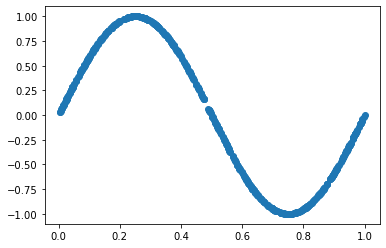

In [66]:
np.random.seed(42)
X = np.random.uniform(0.0,1.0,(600,))
y = np.sin(2*X * math.pi)

plt.scatter(X, y)
losses = []

In [67]:
epochs = 100
for epoch in range(epochs):
    error = 0.0
    dts = 0
    for i in range(600):
        arduino.write(b"t")
        arduino.write(struct.pack('f', X[i]))
        arduino.write(struct.pack('f', y[i]))
        dt = arduino.read(4)
        [dt] = struct.unpack('i', dt)
        n_error = arduino.read(4)
        [loss] = struct.unpack('f', n_error)
        error += loss
        dts += dt
    if epoch%10 == 0:
        print(f"{epoch}/{epochs} => {error/600.0}, {dt}ms")
    losses.append(error / 600.0)


0/100 => 0.006340058133893916, 354ms
10/100 => 0.00544748150815046, 348ms
20/100 => 0.0047395883085448055, 349ms
30/100 => 0.004164646877533803, 359ms
40/100 => 0.003682659465189471, 349ms
50/100 => 0.003267761798553069, 350ms
60/100 => 0.002904829612770866, 344ms
70/100 => 0.0025860582811294878, 347ms
80/100 => 0.0023078344994538085, 346ms
90/100 => 0.0020668526178760946, 355ms


In [ ]:
plt.plot(loss)

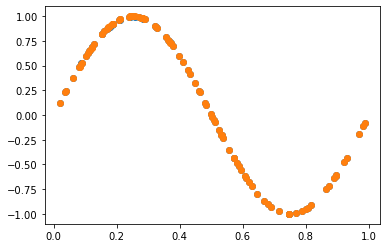

In [367]:
y_preds = []
X_test = np.random.uniform(0.0,1.0,(100,))
y_test = np.sin(2*X_test * math.pi)
for i in range(100):
    arduino.write(b"p")
    arduino.write(struct.pack('f', X_test[i]))
    n_error = arduino.read(4)
    [y_pred] = struct.unpack('f', n_error)
    y_preds.append(y_pred)

plt.scatter(X_test, y_preds)
plt.scatter(X_test, y_test)

## Send data to c++ by sockets

In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import socket
import time
import math

np.random.seed(42)

HOST = '192.168.1.131'  # The server's hostname or IP address
PORT = 65432        # The port used by the server

def send_data(data):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        print(f"Want to send {np.prod(data.shape)} elements.")
        s.connect((HOST, PORT))

        # data length descriptor as uint32
        length_descriptor = np.uint32(np.prod(data.shape)).tobytes(order='C')

        # payload as C-style float32 byte array
        payload = data.astype(np.float32).tobytes(order='C')
        #print(f"Length {np.uint32(np.prod(data.shape))} bytes, payload {payload}")

        s.sendall(length_descriptor + payload)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

datos = pd.read_csv("creditcard.csv")
datos.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
from sklearn.preprocessing import StandardScaler
datos.drop(['Time'], axis=1, inplace=True)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

In [4]:
datos.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [5]:
X_test.shape

(56962, 29)

In [24]:
send_data(X_train)

Want to send 6596079 elements.


In [25]:
send_data(X_test)

Want to send 1651898 elements.


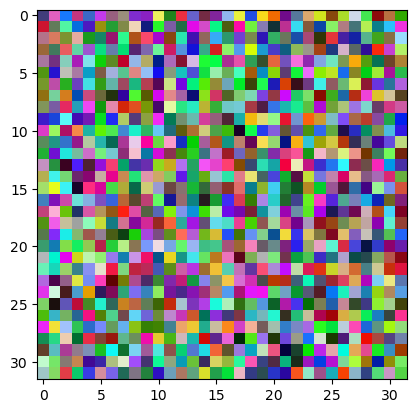

In [21]:
img = np.random.rand(32,32,3)
import matplotlib.pyplot as plt

plt.imshow(img)

In [301]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [302]:
from keras.utils import np_utils
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)

Shape before one-hot encoding:  (60000,)


In [303]:
Y_train.shape, X_train.shape

((60000, 10), (60000, 28, 28))

In [310]:
send_data(X_train)
send_data(Y_train)

Want to send 47040000 elements.
Want to send 600000 elements.


In [311]:
Y_test = np_utils.to_categorical(y_test, n_classes)

In [312]:
send_data(X_test)
send_data(Y_test)

Want to send 7840000 elements.
Want to send 100000 elements.


In [241]:
from sklearn.datasets import load_digits
digits = load_digits()
X_train, y_train = digits.data[:1000], digits.target[:1000]
X_test, y_test = digits.data[1000:], digits.target[1000:]
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [298]:
send_data(X_train)
send_data(Y_train)
send_data(X_test)
send_data(Y_test)

Want to send 64000 elements.
Want to send 10000 elements.
Want to send 51008 elements.
Want to send 7970 elements.


In [157]:
X_train[0].shape

(64,)

In [50]:
np.random.seed(42)
X = np.random.uniform(0.0,1.0,(600,))
y = np.sin(2*X * math.pi)
send_data(X)
send_data(y)

Want to send 600 elements.
Want to send 600 elements.
